Channel is 51.2 for no time offset (4.5 ns)

In [ ]:
import uncertainties.unumpy as unp
import uncertainties as u
from uncertainties.umath import log


from uncertainties import ufloat
import numpy as np
import pandas as pd
import scipy as sp
import kafe2
import matplotlib.pyplot as plt
import os
import glob
import struct
import sympy
from scipy.optimize import curve_fit

from pathlib import Path



In [61]:
def gauss (x,A,sigma,µ):
    return A/np.sqrt(2*np.pi*sigma**2)*np.exp(-(x-µ)**2/(2*sigma**2))
directory =  Path().resolve()/Path("162")

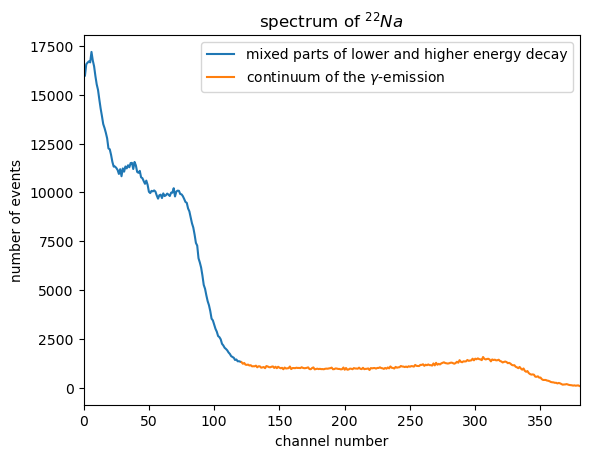

In [35]:
Na_22 = np.genfromtxt("./162/Na22_spectrum.txt")
cutoff=120
plt.title("spectrum of $^{22}Na$")
plt.ylabel("number of events")
plt.xlabel("channel number")
plt.plot(Na_22[:cutoff,0], Na_22[:cutoff,1], label="mixed parts of lower and higher energy decay")
plt.plot(Na_22[cutoff:,0], Na_22[cutoff:,1],label="continuum of the $\gamma$-emission")
plt.legend()
plt.xlim(0,380)
plt.show()


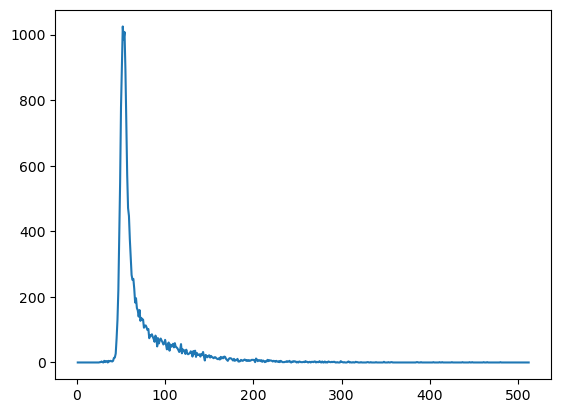

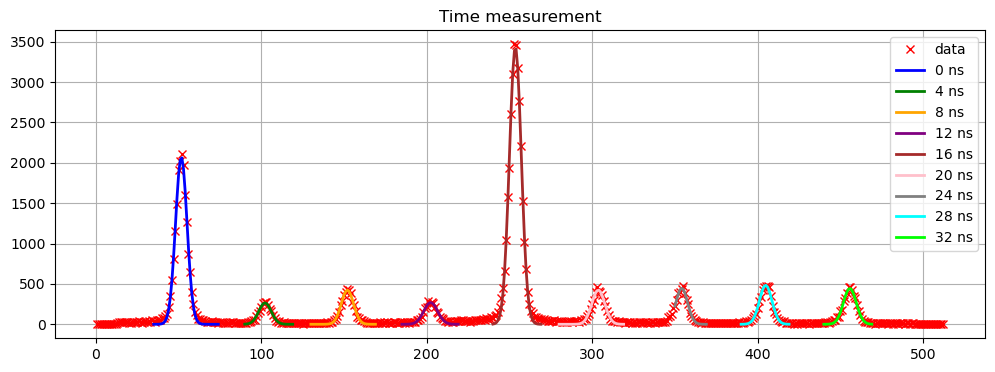

In [118]:
time_limit_list=[[35, 75], [90, 120], [130, 170], [185, 220], [240, 270], [280, 320], [350, 370], [390, 420], [440, 470]]
colors = ['blue','green','orange','purple', 'brown','pink', 'gray', 'cyan', 'lime']
t_mu_list=[]
t_error_list=[]
arr = np.genfromtxt(directory/"Zeitaulsg.txt").T
# plt.plot(arr[0],arr[1])
# plt.grid(1)
# plt.show()


x = np.linspace(0,500,501)
plt.figure(figsize=(12, 4))
plt.plot(arr[0],arr[1], "rx", label="data")

for i,limit in enumerate(time_limit_list):

    p_0 = [2000, 10, (limit[0]+limit[1])/2]

    par, cov= curve_fit(gauss, arr[0][limit[0]:limit[1]], arr[1][limit[0]:limit[1]], p0= p_0)
    sigma, mu = np.abs(par[1]), par[2]
    n_events = np.sum(arr[1][round(mu-sigma)-1:round(mu+sigma)-1]) ## sum of events in one sigma interval
    t_error_list.append(sigma/np.sqrt(n_events))
    t_mu_list.append(mu)
    plt.plot(x[limit[0]:limit[1]], gauss(x, par[0],par[1],par[2])[limit[0]:limit[1]],label = str(i*4)+" ns",linewidth = 2,color=colors[i])

plt.title("Time measurement")
plt.grid(1)
plt.legend()
# plt.xlim(limit[0], limit[1])

plt.show()

times_cal_arr = unp.uarray(t_mu_list,t_error_list)

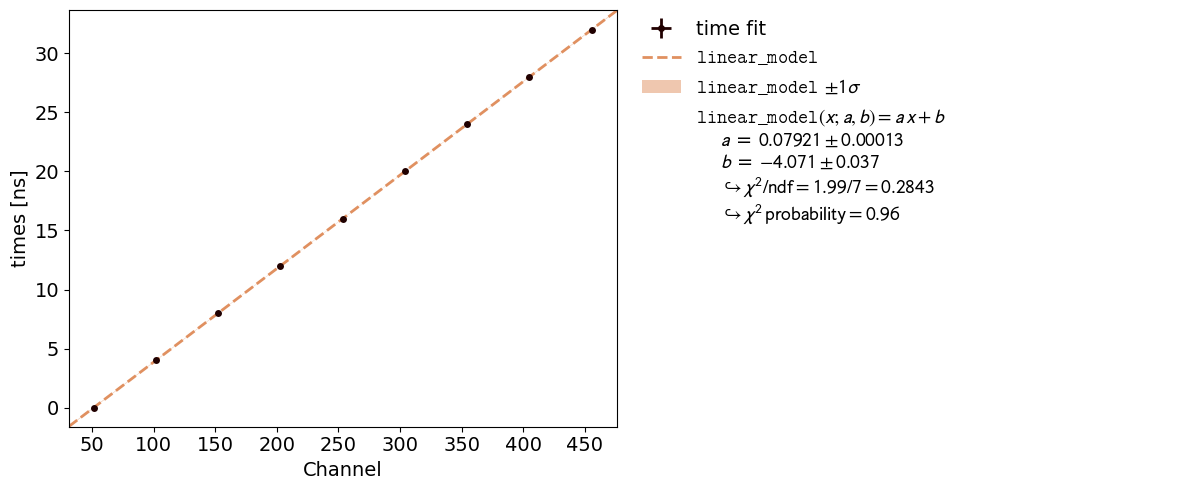

26.822853610024204+/-0.062078047991093836

In [150]:

data = kafe2.XYContainer(unp.nominal_values(times_cal_arr), range(0,33,4))
data.label = 'time fit'
#print(times_cal_arr)
data.add_error('x', unp.std_devs(times_cal_arr))
data.add_error('y', 0.05)


fit_time = kafe2.Fit(data)
fit_time.do_fit()
p = kafe2.Plot(fit_time)
p.y_label = 'times [ns]'
p.x_label = 'Channel' 
p.plot()
plt.show()

def timeConversion(channel,error=False):
    """
    returns the corresponding time

    Args:
        float/ufloat: time
        error: return ufloat

    Returns:
        float: time [ns]
        ufloat: time [ns]
    """
    global fit_time
    
    if error:
        return (u.ufloat(fit_time.parameter_values[0], fit_time.parameter_errors[0])*channel+u.ufloat(fit_time.parameter_values[1], fit_time.parameter_errors[1]))
    return (fit_time.parameter_values[0]*channel+fit_time.parameter_values[1])

timeConversion(390,True)

$N(t)=A\cdot e^{-\frac{t}{\tau_1}}+B\cdot e^{-\frac{t}{\tau_2}}+C$

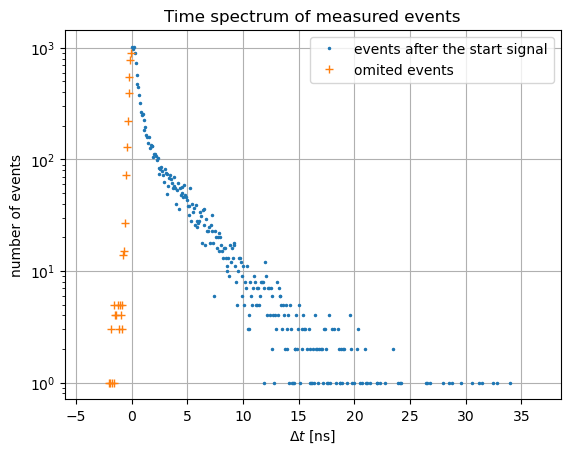

In [331]:
dif_time = np.genfromtxt("./162/Zeitmessung.txt").T
cutoff=51
plt.plot(timeConversion(dif_time[0][cutoff:]), dif_time[1][cutoff:],".",markersize=3, label="events after the start signal")

plt.plot(timeConversion(dif_time[0][0:cutoff]), dif_time[1][0:cutoff],"+",label="omited events")
plt.grid(1)
plt.xlabel("$\Delta t$ [ns]")
plt.ylabel("number of events")
plt.legend()
plt.title("Time spectrum of measured events")
plt.yscale("log")
plt.show()




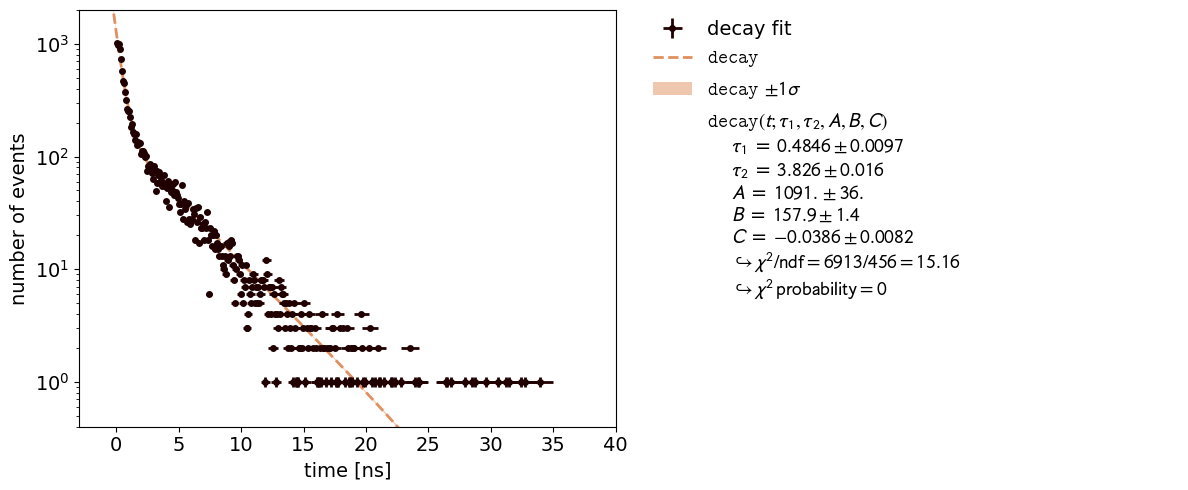

In [242]:
def decay(t,tau_1=0.6 , tau_2=2 , A=1400, B=1, C=0.8):
    return A*np.exp(-t/ (tau_1))+B*np.exp(-t/ (tau_2)) + C
data = kafe2.XYContainer(timeConversion(dif_time[0][cutoff:]), dif_time[1][cutoff:])
data.label = 'decay fit'
#print(decays_cal_arr)
data.add_error('x', 0.03,relative=True)

data.add_error('x', unp.std_devs(timeConversion(dif_time[0][cutoff:],True)))

data.add_error('y', 0.1)


fit_decay = kafe2.Fit(data,decay)
fit_decay.do_fit()
p = kafe2.Plot(fit_decay)
p.x_label = 'time [ns]'
p.y_label = 'number of events' 
p.x_range = (-3, 40)
p.y_scale ="log"
p.y_range = (0.4, 2000)

p.plot()
plt.show()

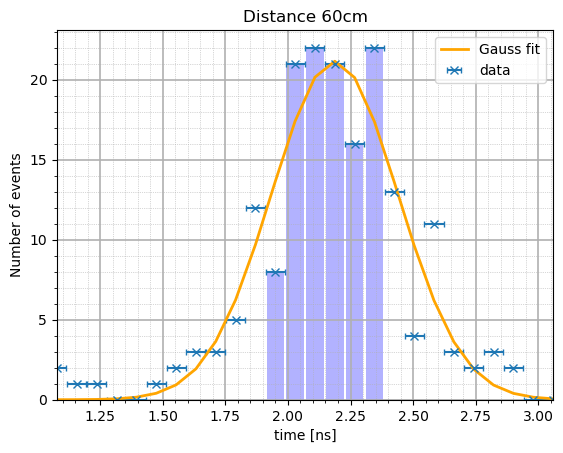

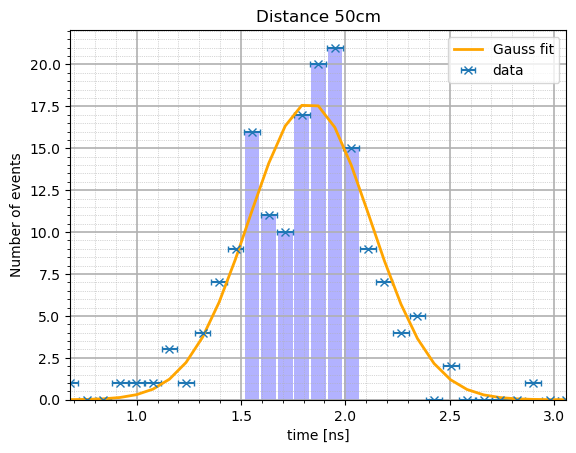

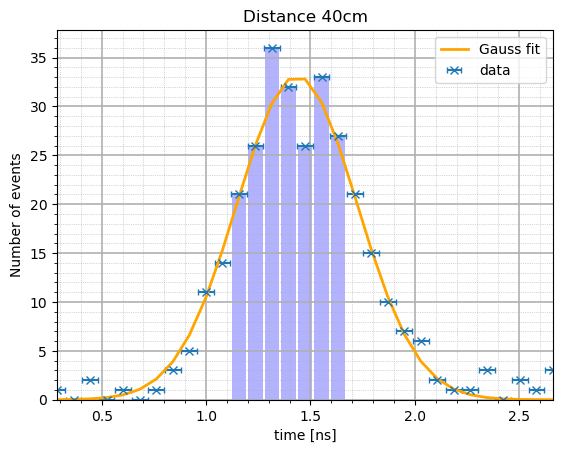

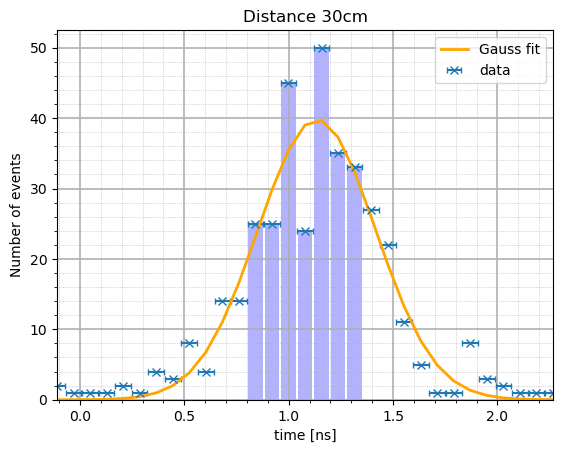

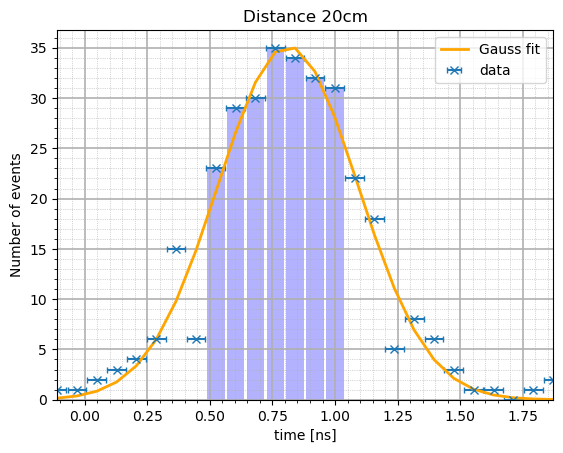

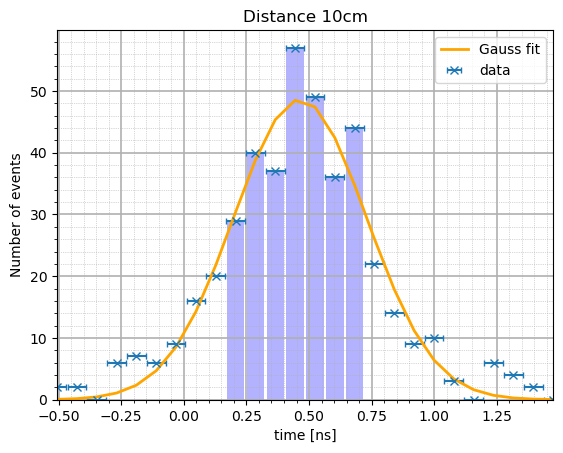

In [311]:
c_file_list = [[x, x.split(".")[-2].split("\\")[-1]] for x in sorted(glob.glob(os.path.join(directory, '*.txt')), key=os.path.getmtime, reverse=True) if ("cm" in x)]
limit_list=[[65,90],[60,90],[55,85],[50,80],[50,75],[45,70]]

c_mu_list=[]
c_error_list=[]


x = np.linspace(0, 100, 101)

for i, file in enumerate(c_file_list):
    arr = np.genfromtxt(file[0]).T
    plt.errorbar(timeConversion(arr[0]), arr[1], xerr=unp.std_devs(timeConversion(arr[0],True)) ,label="data",fmt="x",capsize=2)
    beg_ch = 30
    end_ch = 80
    p_0 = [20, 10, (end_ch + beg_ch) / 2]

    par, cov = curve_fit(gauss, arr[0], arr[1], p0=p_0)
    sigma, mu = np.abs(par[1]), par[2]
    n_events = np.sum(arr[1][round(mu - sigma) - 1:round(mu + sigma) - 1])  # sum of events in one sigma interval
    c_error_list.append(sigma / np.sqrt(n_events))
    c_mu_list.append(mu)
    plt.plot(timeConversion(x), gauss(x, par[0], par[1], par[2]), "orange", label="Gauss fit", linewidth=2)

    plt.bar(timeConversion(arr[0][round(mu - sigma) - 1:round(mu + sigma) - 1]), arr[1][round(mu - sigma) - 1:round(mu + sigma) - 1], 0.07, color = "blue", alpha = 0.3)

    plt.ylabel("Number of events")
    plt.xlabel("time [ns]")
    plt.title("Distance " + str(file[1]))
    plt.minorticks_on()  # Turn on minor ticks
    plt.grid(visible=True, which='both', linestyle='-', linewidth=1.2, alpha=1)  # Major and minor grids
    plt.grid(visible=True, which='minor', linestyle=':', linewidth=0.5, alpha=1) 
    
    plt.legend()
    plt.xlim(timeConversion(limit_list[i][0]), timeConversion(limit_list[i][1]))

    plt.show()

c_times = timeConversion(unp.uarray(c_mu_list, c_error_list), True) * 1e-9



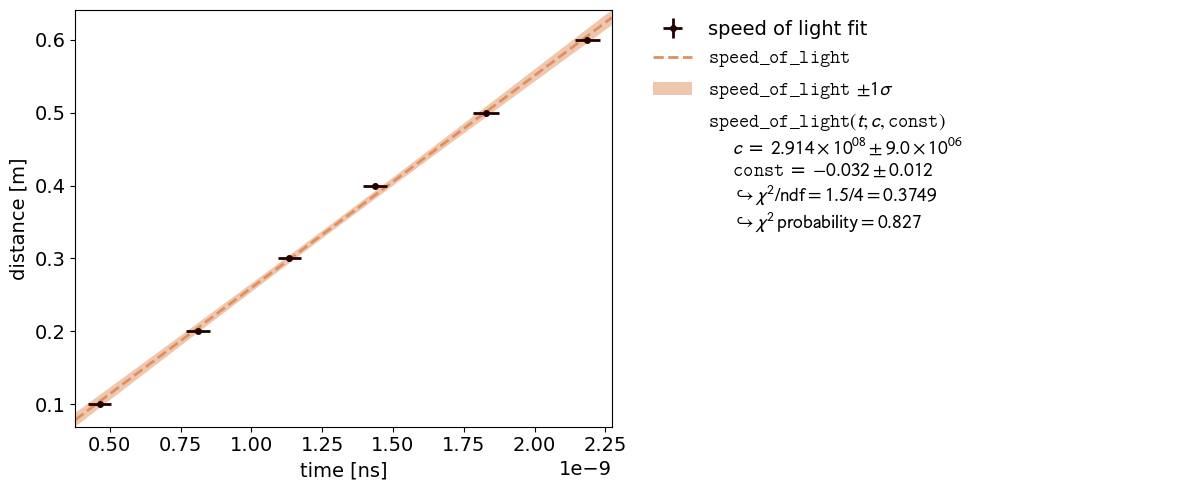

In [156]:
def speed_of_light(t,c,const):
    return c*t+const
data = kafe2.XYContainer(unp.nominal_values(c_times),[0.6, 0.5, 0.4, 0.3, 0.2, 0.1])
data.label = 'speed of light fit' 
data.add_error('x', unp.std_devs(c_times))
data.add_error('y', 0.003)
fit_c = kafe2.Fit(data,speed_of_light)
fit_c.do_fit()
p = kafe2.Plot(fit_c)
p.x_label = 'time [ns]'
p.y_label = 'distance [m]' 
p.plot()
plt.show()